# Boltzmann マシン

## Boltzmann マシン
(Boltzmann machine)

## 制限 Boltzmann マシン
(Restricted Boltzmann machine) 
(cf.) <http://deeplearning.net/tutorial/rbm.html>

データの読み込み

In [1]:
using MLDatasets
using PyPlot
using Random
using ProgressMeter

In [2]:
train_x, _ = MNIST.traindata()
size(train_x)

(28, 28, 60000)

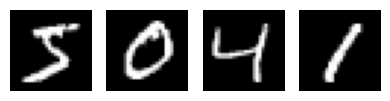

In [3]:
figure(figsize=(4, 1.5))
for i in 1:4
    subplot(1,4,i)
    imshow(train_x[:, :, i]', cmap="gray")
    axis("off")
end
tight_layout()

In [4]:
num_data = 100
input_size = 28*28
data = train_x[:, :, 1:num_data]
data = reshape(data, (input_size, num_data))'

println(size(data))

(100, 784)


In [5]:
width = 28   # MNIST dataの幅
num_v = input_size # visible variables
num_h = 100 # hidden variables
num_units = num_v + num_h # all units
η = 0.01 # learning rate
num_epoch = 50 # epoch of learning 
num_draws = 20  # The number of samples to draw

20

離散の観測変数(visible variable) $\mathbf{v}$, 潜在変数(hidden variable) $\mathbf{h}$とする．各ユニットの値は$\{0, 1\}$の2値 (binary)である．

エネルギー関数を

$$
E_\theta(\mathbf{v}, \mathbf{h})=-\mathbf{b}^T \mathbf{v} - \mathbf{c}^T \mathbf{h} + \mathbf{v}^T \mathbf{W} \mathbf{h}
$$

とする．ただし，$\theta=\{\mathbf{W}, \mathbf{b}, \mathbf{c}\}$

In [6]:
# sigmoid function 
sigmoid(x) = 1 / (1+exp(-x))

# Initial parameters
W = 0.2 * randn(num_h, num_v)
hbias = 0.2* randn(num_h, 1)
vbias = 0.2 * randn(num_v, 1)

println(size(W), size(hbias), size(vbias))

(100, 784)(100, 1)(784, 1)


シグモイド関数を

$$
\sigma(x) = \frac{1}{1+\exp(-x)}
$$

とする．

### 訓練データで学習

$$
\begin{align}
p_\theta(\mathbf{h}|\mathbf{v})&=\prod_i p_\theta(h_i=1|\mathbf{v})=\prod_i \sigma(c_i + W_i \mathbf{v})\\
p_\theta(\mathbf{v}|\mathbf{h})&=\prod_j p_\theta(v_j=1|\mathbf{h})=\prod_j \sigma(b_j + W_j^T \mathbf{h})
\end{align}
$$

In [7]:
@showprogress "Computing..." for epoch in 1:num_epoch
    for i in 1:num_data
        input = data[i, :]
        h_given_v = sigmoid.(W * input + hbias)
        v = 0.5 * ones(num_v, 1) # init state
        h = 0.5 * ones(num_h, 1) # init state
        sum_v = zeros(num_v, 1)
        sum_h = zeros(num_h, 1)
        outerprod = zeros(num_h, num_v)

        for _ in 1:num_draws
            h = 1.0f0 * (sigmoid.(W * v + hbias) .≥ rand(num_h, 1)) # hidden 
            v = 1.0f0 * (sigmoid.(W' * h + vbias) .≥ rand(num_v, 1)) # visible
            #h = floor.(sigmoid.(W * v + hbias) + rand(num_h, 1)) # hidden 
            #v = floor.(sigmoid.(W' * h + vbias) + rand(num_v, 1)) # visible
            sum_h += h
            sum_v += v
            outerprod += h * v'
        end
            
        sum_h /= num_draws
        sum_v /= num_draws
        outerprod /= num_draws
        
        # update parameters
        W += η * (h_given_v * input' - outerprod)
        hbias += η * (h_given_v - sum_h)
        vbias += η * (input - sum_v)
    end
end

Computing... 100%|███████████████████████████████████████| Time: 0:00:39


二項分布 (bernoulli distribution)のサンプリングには2通りある．`1.0f0`を乗じているのはBool変数からFloatへの変換のため．詳細はtips.

### テストデータで確認

In [8]:
num_draws_test = 50 # draws for in test
num_see = 392  # Visible units in test
noise_scale = 0.1 # テスト時のノイズレベル
num_testdata = 4

4

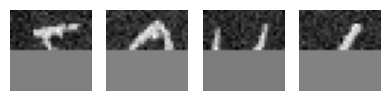

In [9]:
testdata = data[1:num_testdata, :] + noise_scale * randn(num_testdata, input_size)
testdata[:, num_see+1:num_v] .= 0.5

figure(figsize=(4, 1.5))
for i in 1:4
    subplot(1,4,i)
    imshow(reshape(testdata[i, :], (width, width))', cmap="gray")
    axis("off")
end
tight_layout()

In [10]:
energy(v, h) = -v' * vbias - h' * hbias - h' * W * v
# free_energy(v) = -v' * vbias .- sum(log.(1 .+ exp.(W * v + hbias)))

energy (generic function with 1 method)

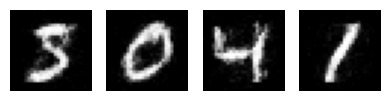

In [11]:
# Results of Test data
energy_arr = zeros(num_testdata, num_draws_test)
figure(figsize=(4, 1.5))

for i in 1:num_testdata
    v = 0.5 * ones(num_v, 1) # init state
    h = 0.5 * ones(num_h, 1) # init state
    sum_v = zeros(num_v, 1)
    for j in 1:num_draws_test
        v[1:num_see, 1] = testdata[i, 1:num_see]'
        h = 1.0f0 * (sigmoid.(W * v + hbias) .≥ rand(num_h, 1))
        v = 1.0f0 * (sigmoid.(W' * h + vbias) .≥ rand(num_v, 1))
        sum_v += v
        energy_arr[i, j] = energy(v, h)[1]
    end
    sum_v /= num_draws_test
    
    # show
    subplot(1,4,i)
    imshow(reshape(sum_v, (width, width))', cmap="gray")
    axis("off")
end

tight_layout()

エネルギーの変化を見る

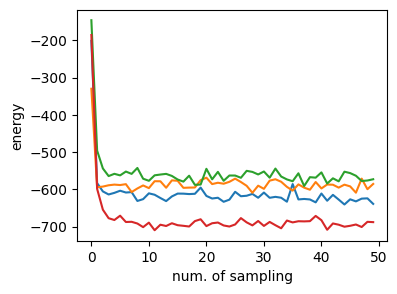

In [12]:
figure(figsize=(4,3))
ylabel("energy")
xlabel("num. of sampling")
for i in 1:4
    plot(energy_arr[i, :])
end

### 受容野の可視化

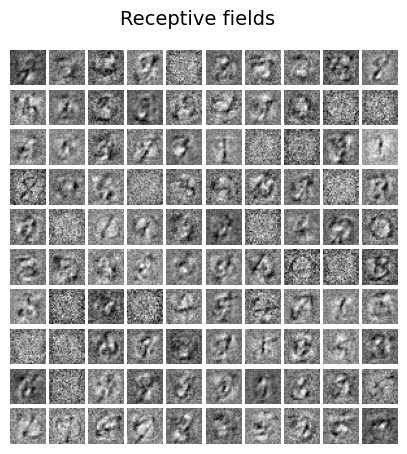

In [13]:
# Plot Receptive fields
figure(figsize=(5, 5))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:num_h
    subplot(10, 10, i)
    imshow(reshape(W[i, :], (width, width))', cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.9)